In [1]:
import pandas as pd
import igraph as ig
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from collections import Counter

In [2]:
datadir='../Datasets/'

### Problem 1
For each of the three GitHub Developers graphs (the ml developers, the web developers, and the original one), do the following:
1. plot the degree correlation function $k_{nn}(l)$ and its uncorrelated counterpart $\hat{k}_{nn} (l)$

In [3]:
## read edges and make graph
github_df = pd.read_csv(datadir+'GitHubDevelopers/musae_git_edges.csv')
gh = ig.Graph.DataFrame(github_df, directed=False)

## read node features
X = pd.read_csv(datadir+'GitHubDevelopers/musae_git_target.csv')

## map node names in edgelist to indices in the graph
idx = [int(i) for i in gh.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['id'].map(sorterIndex) 
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)

lbl = ['web','ml']     ## node labels
gh.vs['lbl'] = [lbl[i] for i in list(X['ml_target'])]

## build the ml and wb subgraphs
gh_ml = gh.subgraph([v for v in gh.vs() if v['lbl']=='ml'])
gh_wb = gh.subgraph([v for v in gh.vs() if v['lbl']=='web'])

Degree correlation functions taken from the Chapter 4 notebook:

In [3]:
## Degree correlation functions

# undirected
def deg_corr(G):
    idx = {v:k for k,v in enumerate([i for i in set(G.degree())])}
    idx_inv = {k:v for k,v in enumerate(idx)}
    deg = G.degree()
    L = [[] for i in range(len(idx))]
    for v in G.vs():
        w = [deg[i] for i in G.neighbors(v)] 
        L[idx[v.degree()]].extend(w)
    return {idx_inv[i]:np.mean(L[i]) for i in range(len(L))}

## degree correlation for neutral graph with degree distribution in G
def deg_corr_neutral(G, mode='all'):
    x = G.degree(mode=mode)
    return np.mean([i**2 for i in x])/np.mean(x)    

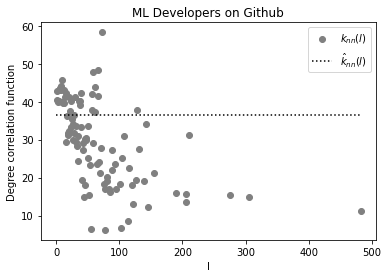

In [9]:
knn_ml = deg_corr(gh_ml)
x = list(knn_ml.keys())
y = list(knn_ml.values())
r = deg_corr_neutral(gh_ml)
plt.scatter(x,y,c='grey', label='$k_{nn}(l)$')
plt.hlines(r,xmin=min(x),xmax=max(x),linestyles=':',colors='k',label='$\hat{k}_{nn}(l)$')
plt.title("ML Developers on Github")
plt.xlabel('l')
plt.ylabel("Degree correlation function")
plt.legend(loc='best')
plt.show()

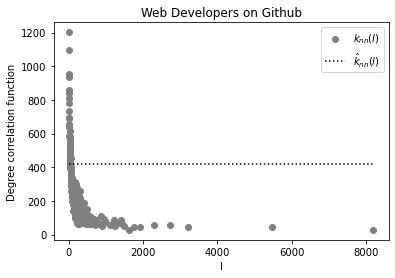

In [10]:
knn_wb = deg_corr(gh_wb)
x = list(knn_wb.keys())
y = list(knn_wb.values())
r = deg_corr_neutral(gh_wb)
plt.scatter(x,y,c='grey', label='$k_{nn}(l)$')
plt.hlines(r,xmin=min(x),xmax=max(x),linestyles=':',colors='k',label='$\hat{k}_{nn}(l)$')
plt.title("Web Developers on Github")
plt.xlabel('l')
plt.ylabel("Degree correlation function")
plt.legend(loc='best')
plt.show()

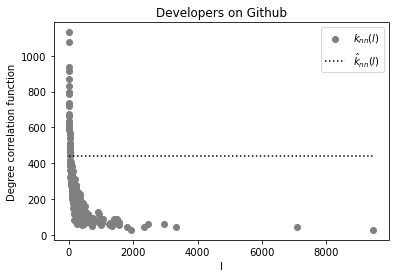

In [95]:
knn = deg_corr(gh)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(gh)
plt.scatter(x,y,c='grey', label='$k_{nn}(l)$')
plt.hlines(r,xmin=min(x),xmax=max(x),linestyles=':',colors='k',label='$\hat{k}_{nn}(l)$')
plt.title("Developers on Github")
plt.xlabel('l')
plt.ylabel("Degree correlation function")
plt.legend(loc='best')
plt.show()

2. find the degree correlation coefficent $r$

In [21]:
r = [gh_ml.assortativity_degree(), gh_wb.assortativity_degree(), gh.assortativity_degree()]

df = pd.DataFrame(r,index=['ML Developers','Web Developers','All Developers'], columns=['r'])
df.head()

,r
ML Developers,-0.090987
Web Developers,-0.087148
All Developers,-0.075217


3. find the correlation exponent $\mu$

Using code from the Chapter 4 notebook:

In [22]:
def corr_exp(G):
    ## compute knn's
    knn = deg_corr(G)
    # Fit the regression
    regressor = LinearRegression()  
    x = [np.log(i) for i in knn.keys()]
    y = [np.log(i) for i in knn.values()]
    regressor.fit(np.array(x).reshape(-1,1), y)
    return regressor.coef_[0]

In [35]:
## remove unconnected nodes from ML and WEB subgraphs
gh_ml.vs()['degree'] = gh_ml.degree()
gh_ml = gh_ml.subgraph([v for v in gh_ml.vs() if v['degree']>=1])

gh_wb.vs()['degree'] = gh_wb.degree()
gh_wb = gh_wb.subgraph([v for v in gh_wb.vs() if v['degree']>=1])

mu = [corr_exp(gh_ml), corr_exp(gh_wb), corr_exp(gh)]

df = pd.DataFrame(mu,index=['ML Developers','Web Developers','All Developers'], columns=['$\mu$'])
df.head()

,$\mu$
ML Developers,-0.251423
Web Developers,-0.515104
All Developers,-0.507688


4. plot the rich-club coefficient $\rho(l)$

Using code from the Chapter 4 notebook:

In [15]:
def rich_club(g, l=1):
    g.vs()['degree'] = g.degree()
    l_max = np.max(g.degree())
    c = Counter(g.degree())
    n = g.vcount()
    moment = np.sum([k*c[k]/n for k in c])**2
    S = [k*c[k]/n for k in c if k>=l]
    phi_hat = np.sum([x*y for x in S for y in S])*g.ecount()/moment
    G = g.subgraph([v for v in g.vs() if v['degree']>=l])
    phi = G.ecount()
    return phi/phi_hat   

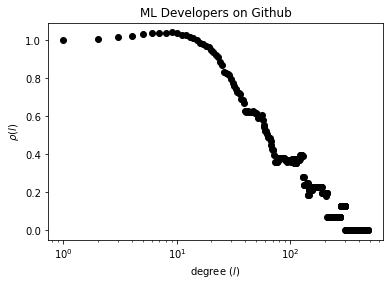

In [42]:
max_degree = max(gh_ml.degree())
l = np.arange(1, max_degree)
rc = np.zeros(len(l))
for i in range(len(l)):
    rc[i] = rich_club(gh_ml, l=l[i])
plt.scatter(l, rc, color='k')
plt.xlabel('degree ($l$)')
plt.ylabel(r'$\rho (l)$')
plt.xscale('log')
plt.title('ML Developers on Github')
plt.show()

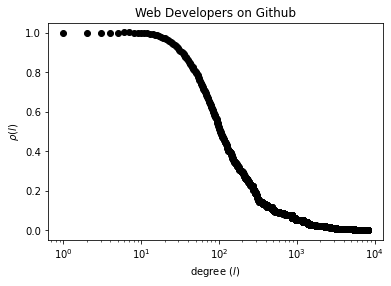

In [43]:
max_degree = max(gh_wb.degree())
l = np.arange(1, max_degree)
rc = np.zeros(len(l))
for i in range(len(l)):
    rc[i] = rich_club(gh_wb, l=l[i])
plt.scatter(l, rc, color='k')
plt.xlabel('degree ($l$)')
plt.ylabel(r'$\rho (l)$')
plt.xscale('log')
plt.title('Web Developers on Github')
plt.show()

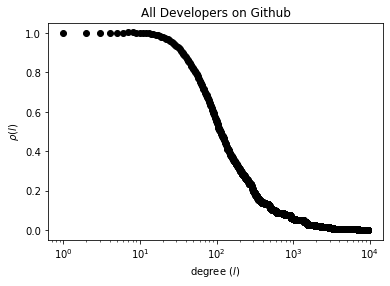

In [44]:
max_degree = max(gh.degree())
l = np.arange(1, max_degree)
rc = np.zeros(len(l))
for i in range(len(l)):
    rc[i] = rich_club(gh, l=l[i])
plt.scatter(l, rc, color='k')
plt.xlabel('degree ($l$)')
plt.ylabel(r'$\rho (l)$')
plt.xscale('log')
plt.title('All Developers on Github')
plt.show()

### Problem 2
Starting with the original GitHub Developers graph, apply the switching method to get the randomized degree correlation function $\bar{k}_{nn} (l)$. Compare it with the degree correlation function $k_{nn}(l)$ and its uncorrelated counterpart $\hat{k}_{nn} (l)$. What is your conclusion?

In [ ]:
## read edges and make graph
github_df = pd.read_csv(datadir+'GitHubDevelopers/musae_git_edges.csv')
gh = ig.Graph.DataFrame(github_df, directed=False)

## plot degree correlation function and uncorrelated counterpart
knn = deg_corr(gh)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(gh)
plt.scatter(x,y,c='grey', label='$k_{nn}(l)$')
plt.hlines(r,xmin=min(x),xmax=max(x),linestyles=':',colors='grey',label='$\hat{k}_{nn}(l)$')
plt.title("Developers on Github")
plt.xlabel('l')
plt.ylabel("Degree correlation function")

assert gh.is_simple()

edges = tuple(gh.es.indices)

## the order of edges in gh.es.indices will change as we add and remove edges
## for each edge, I want to fix its identity using its original index.
## These will be the keys in this dictionary. The values will be the source, target, and
## whether it has been flipped at least once
edge_dict = dict.fromkeys(edges)

for e in gh.es:
    edge_dict[e.index] = [e.source, e.target, 0]
    
flipped = np.array(list(edge_dict.values()))[:,-1]
    
completed = 0.1
    
while sum(flipped) < len(edges):
    e1, e2 = np.random.choice(edges, size=2, replace=False)
    edge1 = edge_dict[e1]
    edge2 = edge_dict[e2]
    u1 = edge1[0]
    u2 = edge1[1]
    v1 = edge2[0]
    v2 = edge2[1]
    
    ## perform switch
    gh.delete_edges([(u1, u2), (v1, v2)])
    gh.add_edges([(u1, v1), (u2, v2)])
    
    ## if no multiple edges introduced, keep changes
    if gh.is_simple():
        
        edge_dict[e1] = [u1, v1, 1]
        edge_dict[e2] = [u2, v2, 1]
       
    ## otherwise, revert changes
    else:
        gh.delete_edges([(u1, v1), (u2, v2)])
        gh.add_edges([(u1, u2), (v1, v2)])
        
    flipped = np.array(list(edge_dict.values()))[:,-1]   
    
    ## makeshift progress printout:
    if sum(flipped)/len(edges) > completed:
        print("{0}% edges flipped".format(completed*100))
        completed += 0.1
    
    
knn_rand = deg_corr(gh)
xr = list(knn_rand.keys())
yr = list(knn_rand.values())
plt.scatter(xr,yr,c='black', label='$\overline{k}_{nn}(l)$')
plt.legend(loc='best')
plt.show()

Code was too slow to produce output in time.

### Problem 3
Starting with the original GitHub Developers graph, apply the switching method but instead of waiting for all edges to be switched at least once, perform only $cm$ switchings for $c \in \{0.5, 1, 2\}$ ($m$ is the number of edges). For each experiment, plot the (approximated) random degree correlation function $\bar{k}_{nn} (l)$. Independently check how many edges have \textit{not} been switched. (After $cm$ edge switchings, we randomly switch $2cm$ edges and theoretical results imply that we expect $e^{-2c}$ fraction of edges ot remain not switched. You may check if your experiment returns a similar answer.)

In [4]:
def edge_switch(G, edge_dict, no_switches):
    for i in range(no_switches):
        e1, e2 = np.random.choice(edges, size=2, replace=False)
        edge1 = edge_dict[e1]
        edge2 = edge_dict[e2]
        u1 = edge1[0]
        u2 = edge1[1]
        v1 = edge2[0]
        v2 = edge2[1]

        ## perform switch
        gh.delete_edges([(u1, u2), (v1, v2)])
        gh.add_edges([(u1, v1), (u2, v2)])

        ## if no multiple edges introduced, keep changes
        if gh.is_simple():

            edge_dict[e1] = [u1, v1, 1]
            edge_dict[e2] = [u2, v2, 1]

        ## otherwise, revert changes
        else:
            gh.delete_edges([(u1, v1), (u2, v2)])
            gh.add_edges([(u1, u2), (v1, v2)])
            
    return edge_dict

In [ ]:
## read edges and make graph
github_df = pd.read_csv(datadir+'GitHubDevelopers/musae_git_edges.csv')
gh = ig.Graph.DataFrame(github_df, directed=False)

assert gh.is_simple()

edges = tuple(gh.es.indices)

## the order of edges in gh.es.indices will change as we add and remove edges
## for each edge, I want to fix its identity using its original index.
## These will be the keys in this dictionary. The values will be the source, target, and
## whether it has been flipped at least once
edge_dict = dict.fromkeys(edges)

for e in gh.es:
    edge_dict[e.index] = [e.source, e.target, 0]


switches = np.array([0.5, 0.5, 1])*len(edges) ## increments in cm
not_switched = np.zeros(len(switches)) ## fraction of edges not switched
labels = ['c=0.5', 'c=1.0', 'c=2.0']
c = ['lightgray', 'grey', 'black']


for s in range(len(switches)):
    edge_dict = edge_switch(gh, edge_dict, int(switches[s]))
    knn_rand = deg_corr(gh)
    xr = list(knn_rand.keys())
    yr = list(knn_rand.values())
    plt.scatter(xr,yr,c=c[s], label=labels[s])
    
    flipped = np.array(list(edge_dict.values()))[:,-1]
    not_switched[s]=len(flipped[flipped==0])/len(edges)

c = np.array([0.5, 1, 2])
    
plt.xlabel('c')
plt.ylabel('$\overline{k}_{nn}(l)$ approximation')
plt.show()

Code was too slow to produce output in time.

In [ ]:
plt.scatter(c, not_switched, c='grey', label='Experiment')
plt.plot(np.linspace(0.5, 2), np.exp(-2*np.linspace(0.5, 2)), label='Theory')
plt.xlabel('c')
plt.ylabel('$\overline{k}_{nn}(l)$' approximation)
plt.legend(loc='best')
plt.show()

### Problem 5
Use the Chung-Lu model with $n=10\,000$ nodes to generate three graphs with power law degree distribution ($\gamma=2.1$, $\gamma=2.5$, and $\gamma=2.9$), $\delta=1$, and $\Delta =100$. For each of them, investigate the friendship paradox and rich-club behaviour similarly as in Figure 4.8. 

The following cell contains code for generating Chung-Lu graphs from the Chapter 2 Notebook

In [9]:
## fast Chung-Lu: generate m edges w.r.t. distribution d
def fastCL(d, m):
    n = len(d)
    s = np.sum(d)
    p = [i/s for i in d]
    target = m
    tples = []
    ## generate edges (tuples), drop collisions, until m edges are obtained.
    while len(tples) < target:
        s = target - len(tples)
        e0 = np.random.choice(n, size=s, replace=True, p=p)
        e1 = np.random.choice(n, size=s, replace=True, p=p)
        tples.extend([(min(e0[i],e1[i]),max(e0[i],e1[i])) for i in range(len(e0)) if e0[i]!=e1[i]]) ## ignore loops
        tples = list(set(tples)) ## drop collisions
    return tples

In [11]:
def gen_CL(gamma):
    n = 10000
    delta = 1
    Delta = 100

    i = np.arange(1, n+1)
    deg = delta * np.power(n/(i-1+n/(Delta/delta)**(gamma-1)), 1/(gamma-1))
    m = int(np.mean(deg)*n/2)
    tuples = fastCL(deg,m)
    return ig.Graph.TupleList(tuples)

In [12]:
def plot_friendship(G, ax):
    deg = [v.degree() for v in G.vs()]
    ave_neighbour_deg = []
    for v in G.vs():
        nv = G.neighbors(v)
        ave_neighbour_deg.append(np.mean([deg[i] for i in nv]))

    ax.scatter(deg,ave_neighbour_deg,c='black', alpha=0.2)
    ax.set_xlabel('Node Degree')
    ax.set_ylabel('Average Neighbour Degree');
    ax.plot([min(deg), max(deg)],[min(deg), max(deg)],'--', c='gray')
    ax.set_title("Friendship paradox behaviour in Chung-Lu graph")

In [13]:
def plot_rich_club(G, ax):
    max_degree = max(G.degree())
    l = np.arange(1, max_degree)
    rc = np.zeros(len(l))
    for i in range(len(l)):
        rc[i] = rich_club(G, l=l[i])
    ax.scatter(l, rc, color='k')
    ax.set_xlabel('degree ($l$)')
    ax.set_ylabel(r'$\rho (l)$')
    ax.set_xscale('log')
    ax.set_title('Rich-club behaviour of Chung-Lu graph')

Chung-Lu graph with $\gamma=2.1$:

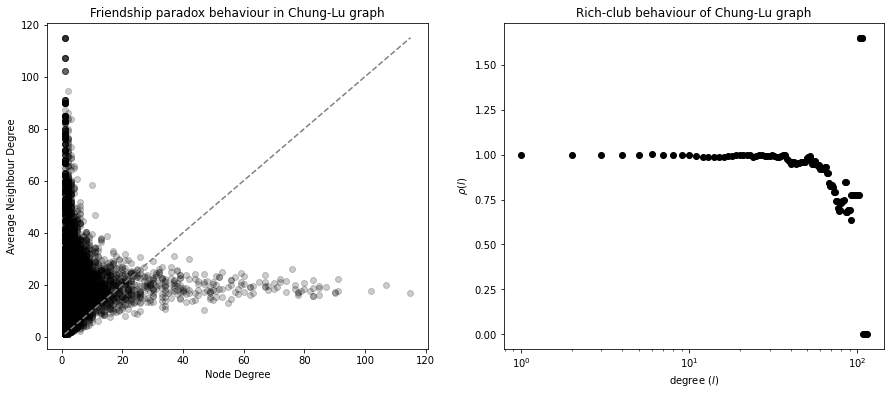

In [17]:
G = gen_CL(2.1)
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
plot_friendship(G, ax[0])
plot_rich_club(G, ax[1])
plt.show()

Chung-Lu graph with $\gamma=2.5$:

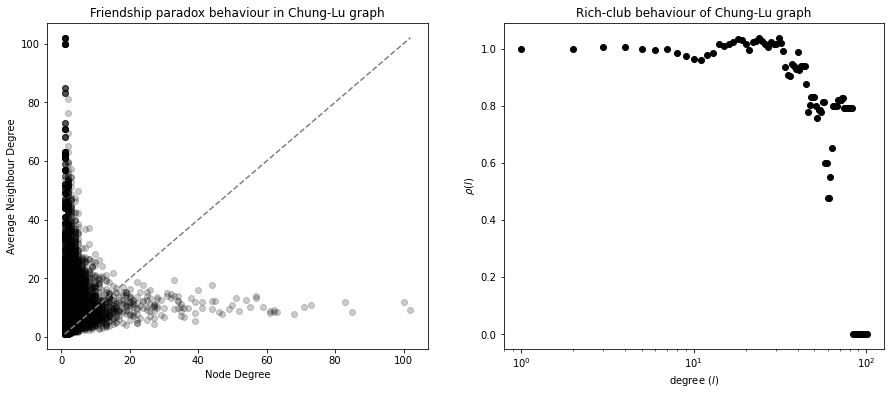

In [18]:
G = gen_CL(2.5)
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
plot_friendship(G, ax[0])
plot_rich_club(G, ax[1])
plt.show()

Chung-Lu graph with $\gamma=2.9$:

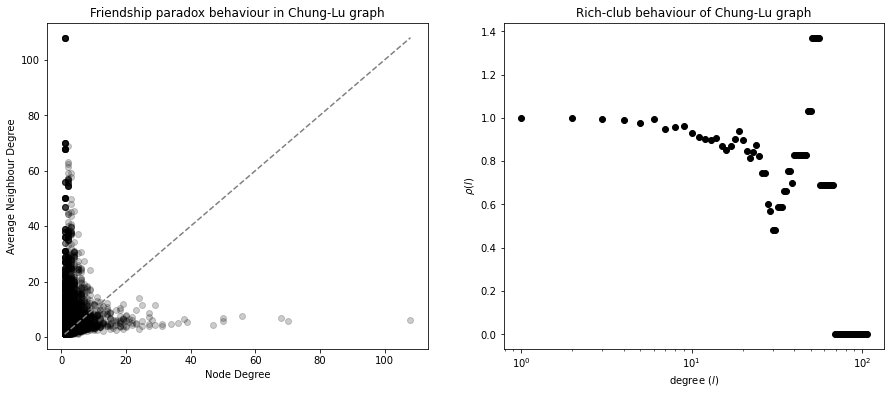

In [19]:
G = gen_CL(2.9)
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
plot_friendship(G, ax[0])
plot_rich_club(G, ax[1])
plt.show()